In [86]:
from sklearn.metrics import f1_score, jaccard_similarity_score, roc_auc_score, classification_report, roc_curve, confusion_matrix
import numpy as np
import scipy
from scipy.stats import threshold
from scipy import misc
import matplotlib.pyplot as plt
import os
import seaborn as sns
from skimage.restoration import denoise_bilateral
sns.set_style('white')
sns.set_context('paper')
%matplotlib inline

In [87]:
actual_pixel_labels, predicted_pixel_labels = np.load("../results/y.npy"), np.load("../results/output.npy")

##Bilateral Filtering

In [88]:
predicted_pixel_labels = np.array([denoise_bilateral(im) for im in predicted_pixel_labels])

##Save random images

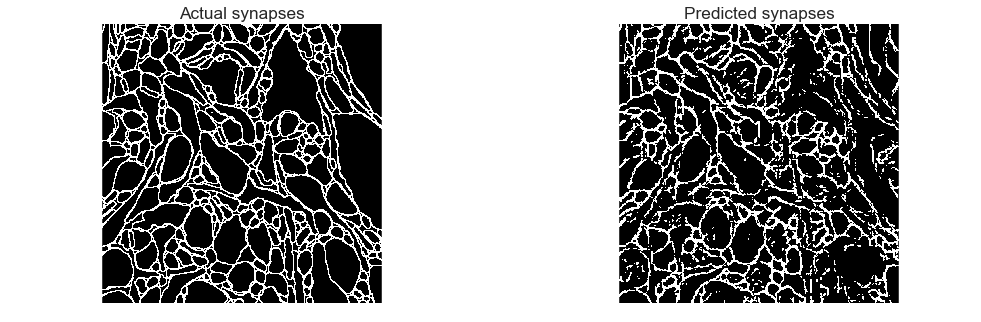

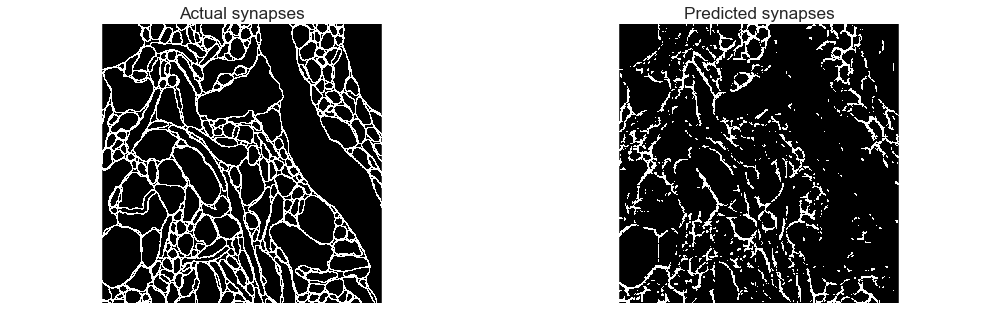

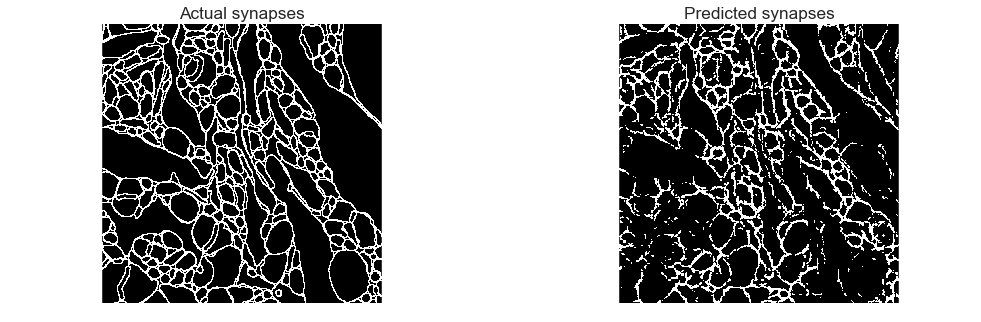

In [89]:
num_images = 3
indices = np.random.choice(actual_pixel_labels.shape[0], num_images, replace=False) 
# create a samples folder within results if it does not yet exist
if not os.path.exists("../results/samples"):
    os.makedirs("../results/samples")

for i, idx in enumerate(indices):
    # Two subplots, unpack the axes array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    f.set_size_inches(17, 5)
    
    
    ax1.imshow(np.around(actual_pixel_labels[idx]), cmap='bone',  interpolation='nearest')
    ax2.imshow(np.around(predicted_pixel_labels[idx]), cmap='bone',  interpolation='nearest')

    ax1.set_title("Actual synapses", fontsize="xx-large")
    ax2.set_title("Predicted synapses", fontsize="xx-large")
    
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    f.savefig("../results/samples/comparison_" + str(i) + ".png")
    misc.imsave('../results/samples/predicted_' + str(i) + '.png', np.around(predicted_pixel_labels[idx]))
    misc.imsave('../results/samples/actual_' + str(i) + '.png', np.around(actual_pixel_labels[idx]))

##Output Stats


In [90]:
def threshold_array(array, threshold):
    y_threshold = np.copy(array)
    y_threshold[np.where( array > threshold )] = 1
    y_threshold[np.where( array <= threshold )] = 0
    return y_threshold

In [91]:
def get_best_threshold_by_f1(y_actual, y_pred):
    f1s = np.empty((1000))
    thresholds = np.linspace(0.01, 1, 1000)
    for i, threshold in enumerate(thresholds):
        y_thresh = threshold_array(y_pred, threshold)
        f1s[i] = f1_score(y_actual, y_thresh, labels=[0, 1], average='binary')
    return thresholds[np.argmax(f1s)]

In [92]:
y_actual = np.around(actual_pixel_labels.flatten())    
p_thresh = get_best_threshold_by_f1(y_actual, predicted_pixel_labels.flatten())
y_predicted = threshold_array(predicted_pixel_labels.flatten(), p_thresh)

f1 = f1_score(y_actual, y_predicted, labels=[0, 1], average='binary')
jaccard = jaccard_similarity_score(y_actual, y_predicted)
auc = roc_auc_score(y_actual, y_predicted)
report = classification_report(y_actual, y_predicted, target_names=["non-synapses", "synapses"])
confusion_mat = confusion_matrix(y_actual, y_predicted)

output_str  = "Probability threshold is " + str(thresholds[np.argmax(f1s)])
output_str +=  "F1 score is " + str(f1) 
output_str += "\nJaccard similarity score is " + str(jaccard)
output_str += "\nROC AUC score is " + str(auc)
output_str += "\nFull Classification Report:\n " + str(report)

print output_str
with open("../results/output_stats.txt", "w") as text_file:
    text_file.write(output_str)

Probability threshold is 1.99999590903F1 score is 0.589180863453
Jaccard similarity score is 0.800464444783
ROC AUC score is 0.763759566158
Full Classification Report:
               precision    recall  f1-score   support

non-synapses       0.92      0.83      0.87   3760782
    synapses       0.51      0.70      0.59    963138

 avg / total       0.83      0.80      0.81   4723920



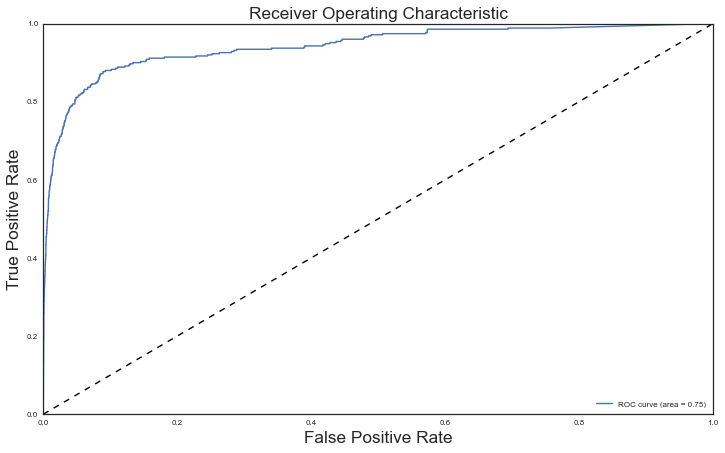

In [16]:
fpr, tpr, thresholds = roc_curve(np.around(actual_pixel_labels.flatten()), predicted_pixel_labels.flatten())
plt.figure(figsize=(12, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize="xx-large")
plt.ylabel('True Positive Rate', fontsize="xx-large")
plt.title('Receiver Operating Characteristic', fontsize="xx-large")
plt.legend(loc="lower right")
plt.savefig("../results/roc_curve.png")
plt.show()

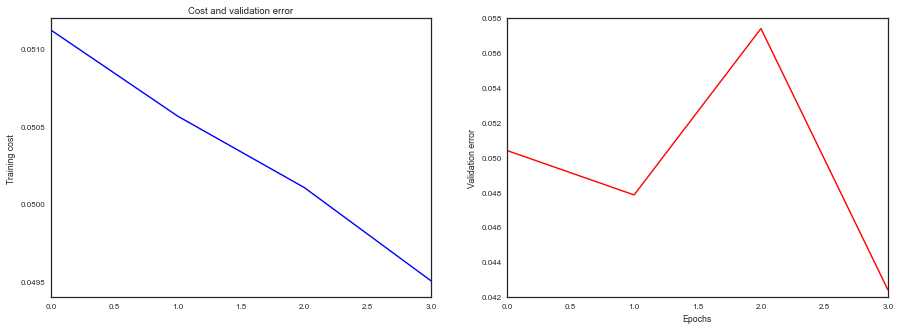

In [88]:
results = np.load('../results/results.npy')

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('Cost and validation error')
ax1.set_ylabel('Training cost')
ax2.set_ylabel('Validation error')
ax2.set_xlabel('Epochs')

ax1.plot(results[0],color = 'blue')
ax2.plot(results[1],color = 'red')
plt.show()


##Post-processing Experiments

1. Median Filter
2. Bilateral Filter

In [68]:
from skimage.restoration import denoise_bilateral
from scipy import ndimage


pred_images = np.copy(predicted_pixel_labels)
actual_images = np.copy(actual_pixel_labels)


#pred_images = np.array([ndimage.median_filter(im, 1) for im in pred_images])
pred_images = np.array([denoise_bilateral(im) for im in pred_images])

# y_predicted = np.around(ndimage.median_filter(predicted_pixel_labels, footprint=np.ones((3,3))))
#y_predicted = np.around(denoise_bilateral(predicted_pixel_labels.flatten()))

y_predicted = np.around(pred_images.flatten())
y_actual = np.around(actual_images.flatten())

f1 = f1_score(y_actual, y_predicted, labels=[0, 1], average='binary')
jaccard = jaccard_similarity_score(y_actual, y_predicted)
auc = roc_auc_score(y_actual, y_predicted)
report = classification_report(y_actual, y_predicted, target_names=["non-synapses", "synapses"])
confusion_mat = confusion_matrix(y_actual, y_predicted)

output_str =  "F1 score is " + str(f1)
output_str += "\nJaccard similarity score is " + str(jaccard)
output_str += "\nROC AUC score is " + str(auc)
output_str += "\nFull Classification Report:\n " + str(report)

print output_str
with open("../results/output_stats.txt", "w") as text_file:
    text_file.write(output_str)

F1 score is 0.479674796748
Jaccard similarity score is 0.988294467307
ROC AUC score is 0.749606488104
Full Classification Report:
               precision    recall  f1-score   support

non-synapses       0.99      0.99      0.99     32455
    synapses       0.46      0.51      0.48       350

 avg / total       0.99      0.99      0.99     32805



In [89]:
y_actual = actual_pixel_labels.flatten()
y_predicted = np.around(predicted_pixel_labels.flatten())
fpr, tpr, thresholds = roc_curve(y_actual, y_predicted)

/usr/local/lib/python2.7/site-packages/sklearn/metrics/ranking.py:292: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.
  not (np.all(classes == [0, 1]) or
/usr/local/lib/python2.7/site-packages/sklearn/metrics/ranking.py:293: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.
  np.all(classes == [-1, 1]) or


ValueError: Data is not binary and pos_label is not specified